In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model

In [300]:
def decode_q_params(encoded_q):
        shape = len(encoded_q)
        mean_shape = 3
        A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
        mean = encoded_q[0:mean_shape]
        A = encoded_q[mean_shape:shape].reshape(A_shape)
        return mean, A
def encode_q_params(q_params):
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))

def decode_d(encoded_d, dim=2):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

def augment_d(d):
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T

In [3]:
enabled = False
def timer(f, label):
    if not enabled:
        return f()
    start_time = time.time()
    res = f()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"{label}: {execution_time} seconds")
    return res

In [4]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=1, decay=0.5, iters=1e1, label=None, leave=True, thres=0.1):
    x = x0
    for i in tqdm(range(int(iters)), desc=label, leave=leave):
        r = rate * 1/(10+i*decay)
        g = gradient(x)
        x = -g * r + x
        #if i > 0 and np.linalg.norm(g) < thres or np.linalg.norm(g) > 10:
        #    break
        if i % 1 == 0:
            if not callback(x, g):
                break
    return x

In [5]:
def log_posterior(theta_i, q_params):
    mean, A = q_params
    #return scipy.stats.multivariate_normal.logpdf(theta_i, mean=mean, cov=A @ A.T)
    return stable_multivariate_gaussian_logpdf(theta_i, mean, A @ A.T)

In [6]:
def stable_multivariate_gaussian_logpdf(x, mu, cov):
    #n = len(x)
    #x_mu = x - mu
    #try:
    #    _, log_det = np.linalg.slogdet(cov)
    #    cov_inv = np.linalg.inv(cov)
    #    log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.dot(x_mu, np.dot(cov_inv, x_mu)))
    #except np.linalg.LinAlgError:
    #    cov_modified = cov + np.eye(n) * 1e-8
    #    _, log_det = np.linalg.slogdet(cov_modified)
    #    cov_inv = np.linalg.inv(cov_modified)
    #    log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.dot(x_mu, np.dot(cov_inv, x_mu)))
    #return log_prob
    #n = cov.shape[-1]
    #x_mu = x - mu
    #try:
    #    _, log_det = np.linalg.slogdet(cov)
    #    cov_inv = np.linalg.inv(cov)
    #    log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.einsum('...i, ...ij, ...j', x_mu, cov_inv, x_mu))
    #except np.linalg.LinAlgError:
    #    cov_modified = cov + np.eye(n) * 1e-8
    #    _, log_det = np.linalg.slogdet(cov_modified)
    #    cov_inv = np.linalg.inv(cov_modified)
     #   log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.einsum('...i, ...ij, ...j', x_mu, cov_inv, x_mu))
    #return log_prob
    n = cov.shape[-1]
    x_mu = x - mu
    try:
        _, log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    except np.linalg.LinAlgError:
        cov_modified = cov + np.eye(n) * 1e-8
        _, log_det = np.linalg.slogdet(cov_modified)
        cov_inv = np.linalg.inv(cov_modified)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    return log_prob
def elbo(q_params, d, y_i, shape=3):
    #print('y_i 2', str(y_i))
    def log_likelihood(y, theta, d):
        #print(y, theta, d)
        likelihood_cov = np.mean(np.square(y - theta.T @ d.T)) * np.eye(len(d))
        likelihood_mean = d @ theta
        return stable_multivariate_gaussian_logpdf(y, likelihood_mean, likelihood_cov)
    def KLD(mean_q, A_q, mean_p, A_p):
        sigma_q = (A_q @ A_q.T)
        sigma_p = (A_p @ A_p.T)
        bar_sigma_q = np.linalg.norm(sigma_q)
        bar_sigma_p = np.linalg.norm(sigma_p)
        k = len(mean_q)
        return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))
    mean, A = q_params
    values = []
    for _ in range(50):
        sample = np.random.multivariate_normal(np.zeros(shape), np.eye(shape))
        theta = mean + A @ sample
        lik = log_likelihood(y_i, theta, d)
        values.append(lik)
    return 1/(len(values))*np.sum(values) - KLD(mean, A, mean_prior, A_prior)

In [429]:

def KLD(mean_q, A_q, mean_p, A_p):
        sigma_q = (A_q @ A_q.T)
        sigma_p = (A_p @ A_p.T)
        bar_sigma_q = np.linalg.norm(sigma_q)
        bar_sigma_p = np.linalg.norm(sigma_p)
        k = len(mean_q)
        return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))
def KLD_opt(mean_q, A_q, mean_p, A_p):
    # Compute Cholesky decomposition
    L_p = np.linalg.cholesky(A_p @ A_p.T)
    L_q = np.linalg.cholesky(A_q @ A_q.T)

    # Compute trace term
    trace_term = np.sum(np.log(np.diag(L_p))) - np.sum(np.log(np.diag(L_q)))

    # Compute mean difference term
    mean_diff = mean_p - mean_q
    mean_diff_term = np.dot(np.linalg.solve(L_p.T, np.linalg.solve(L_p, mean_diff)), mean_diff)

    # Compute bar_sigma_p and bar_sigma_q
    bar_sigma_q = np.linalg.norm(L_q)
    bar_sigma_p = np.linalg.norm(L_p)

    k = len(mean_q)

    return 0.5 * (trace_term + mean_diff_term - k + np.log(bar_sigma_p / bar_sigma_q))
def log_likelihood_opt(y, theta, d):
    d_offset = np.concatenate((d.T, np.ones((1, len(d)))), axis=0).T
    likelihood_cov = np.mean(np.square(y - np.matmul(theta.T, d_offset.T)), axis=1)[:, np.newaxis, np.newaxis] * np.eye(len(d))[np.newaxis, ...]
    likelihood_mean = np.matmul(theta.T, d_offset.T)
    log_likelihoods = stable_multivariate_gaussian_logpdf(y, likelihood_mean, likelihood_cov)
    return log_likelihoods
def log_likelihood(y, theta, d):
    #print(np.array([np.eye(len(d)) for _ in theta.T]).shape)
    d_offset = np.concatenate((d.T, [np.ones(len(d))]), axis=0).T
    #print(np.mean(np.square(y - theta.T @ d.T), axis=1))
    #print(d)
    likelihood_cov = np.mean(np.square(y - theta.T @ d_offset.T), axis=1)[:, np.newaxis, np.newaxis] * np.array([np.eye(len(d)) for _ in theta.T])
    #print(likelihood_cov)
    likelihood_mean = theta.T @ d_offset.T
    return [stable_multivariate_gaussian_logpdf(y, mean, cov) for mean, cov in zip(likelihood_mean, likelihood_cov)]
def elbo_optimized(q_params, d, y_i, shape=3, batch_size = 500):
    #print("Computing elbo for ", q_params, d, y_i)
    mean, A = q_params
    #values = np.random.multivariate_normal(np.zeros(shape), np.eye(shape), size=batch_size)
    #theta = mean + A @ values.T
    sample_values = np.random.multivariate_normal(np.zeros(3), np.eye(3), size=batch_size)
    theta = np.expand_dims(mean, axis=1) + A @ sample_values.T
    lik = timer(lambda: log_likelihood_opt(y_i, theta, d), label="Log Likelihood")
    mean_term = (1/batch_size) * np.sum(lik)
    kld_term = KLD(mean, A, mean_prior, A_prior)
    #print(lik[0])
    
    return mean_term - kld_term
#d0[:, 0]
#np.array([d0[:, 0], d0[:, 1], np.ones(len(d0))]).T
#elbo_optimized((mean_prior, A_prior), d0, mean_prior @ np.array([d0[:, 0], d0[:, 1], np.ones(len(d0))])
#, shape=3)
#elbo((mean_prior[0:2], A_prior[0:2][0:2]), d0, mean_prior[0:2] @ np.array([d0[:, 0], d0[:, 1]])
#, shape=3)

In [562]:
def finite_diff(f, d0):
    return f(d0 + np.ones(len(d0))*1e-7) - f(d0)
def compare_gradients(func, x):
    # Compute gradient using Autograd
    autograd_gradient = grad(func)(x)

    # Compute gradient using finite differences
    epsilon = 1e-6  # Small value for finite differences
    finite_diff_gradient = np.zeros_like(x)
    for i in range(len(x)):
        x_plus_epsilon = x.copy()
        x_plus_epsilon[i] += epsilon
        x_minus_epsilon = x.copy()
        x_minus_epsilon[i] -= epsilon
        finite_diff_gradient[i] = (func(x_plus_epsilon) - func(x_minus_epsilon)) / (2 * epsilon)

    # Compare gradients
    error = np.linalg.norm(autograd_gradient - finite_diff_gradient)
    print("Autograd gradient:", autograd_gradient)
    print("Finite differences gradient:", finite_diff_gradient)
    print("Error:", error)
def log_posterior_grad(theta_i, y_i, d, q_params):
    batch_size=500
    
    def training_hessian_inner(q_params):
        return elbo_optimized(decode_q_params(q_params), d, y_i, batch_size=batch_size)
    
    def training_mixed_partials_inner(encoded_q):
        #print("Encoded d %s" % str(encode_d(d)))
        #print("inner result: %s" % str(encode_d(grad(lambda d: elbo(decode_q_params(encoded_q), d, y_i))(d))))
        def decode_d_y(d_y):
            size = d.shape[0] * d.shape[1]
            return decode_d(d_y[0:size]), d_y[size:]
        def encode_d_y(d, y):
            return np.concatenate((encode_d(d), y_i))
        return encode_d(
            grad(
                lambda d:
                elbo_optimized(
                    decode_q_params(encoded_q), 
                    decode_d(d), 
                    y_i, 
                    batch_size=batch_size
                )
            )(encode_d(d))
        )
    
    def inner_grad_q(encoded_q_params):
        mean, A = decode_q_params(encoded_q_params)
        return stable_multivariate_gaussian_logpdf(theta_i, mean, A @ A.T)
    
    
    training_hessian = timer(lambda: 
                             hessian(training_hessian_inner), 
                             label="\t First hessian computation")
    training_mixed_partials = timer(lambda: 
                                    jacobian(training_mixed_partials_inner), 
                                    label="\t First partial computation")
    
    encoded_q = encode_q_params(q_params)
    latest_hessian = timer(lambda: 
                           training_hessian(encoded_q), 
                           label="\t Second hessian computation"
                          ) # 12 x 12
    grad_log_q = timer(lambda: 
                       grad(inner_grad_q)(encoded_q).reshape(1, len(encoded_q)), 
                       label="\t Grad log q") # 1 x 12
    compare_gradients(training_mixed_partials_inner, encoded_q)
    for i in range(20):
        if np.linalg.det(latest_hessian) != 0:
            evaluated_partials = timer(lambda: training_mixed_partials(encoded_q), label="\t Mixed partials")
            inv = timer(lambda: np.linalg.inv(latest_hessian), label="\t Inverted Hessian")
            print("Grad log q", grad_log_q)
            return (grad_log_q @ (- inv @ evaluated_partials.T))[0]
        latest_hessian = latest_hessian + 1e-8 * np.eye(latest_hessian.shape[0])
    raise ValueError("Was not able to invert hessian")

In [564]:
xs_ = data_sets[0][0]
xs = np.hstack((xs_, np.ones((10, 1))))
zs = np.random.multivariate_normal(np.zeros(10), 3 * np.eye(10))
ys = data_sets[0][1]


reg = linear_model.LinearRegression()
reg.fit(xs_, ys)
print("Regression weights, ", [reg.coef_[0], reg.coef_[1], reg.intercept_])
print("Posterior mean weights, ", analytical_optimal_q(xs_, ys)[0])
g = log_posterior_grad(analytical_optimal_q(xs_, ys)[0] * 2, ys, xs_, analytical_optimal_q(xs_, ys))
auto_g = grad(lambda xs_: log_posterior(analytical_optimal_q(decode_d(xs_), ys)[0], analytical_optimal_q(decode_d(xs_), ys)))(encode_d(xs_) * 2)
print("Grad", g)
print("Autograd", auto_g)
print("MSE", np.mean(np.square(g - auto_g)))
print("norm of grad", np.linalg.norm(g))
print("norm of autograd", np.linalg.norm(auto_g))
#print("Variance of grad", np.var([log_posterior_grad(analytical_optimal_q(xs_, ys)[0], ys, xs_, analytical_optimal_q(xs_, ys), batch_size=20) for _ in trange(100)]))

Regression weights,  [1.4998053100121105, 5.122723523793729, 6.6822670560246]
Posterior mean weights,  [2.27913289 3.11983778 0.22938058]


TypeError: Grad only applies to real scalar-output functions. Try jacobian, elementwise_grad or holomorphic_grad.

In [9]:
# Get returns mean, A for log q to approximate log_posterior
def optimal_q(d, y_i, rate=0.1, decay=0.5, iters=100):
    thetas = []
    def objective_f(encoded_q):
        q_params = decode_q_params(encoded_q)
        return - elbo_optimized(q_params, d, y_i)
    def callback(qi, g):
        mean, A = decode_q_params(qi)
        thetas.append(mean)
        elbos.append(-objective_f(qi))
        g_norms.append(np.linalg.norm(g))
        #print("Elbo: %f.05,\t  grad: %f.05" % (timer(lambda: -objective_f(qi), label="\t ELBO"), np.linalg.norm(g)))
        return True
        #print("\t New ELBO iteration. mean=%s, A=%s" % (str(mean), str(A)))
    results = optimizer(
        encode_q_params(
            (mean_prior, A_prior)
        ), 
        grad(objective_f), 
        callback=callback, 
        label="Optimizing for q", 
        leave=False, 
        rate=rate,
        iters=iters, 
        thres=0.1,
        decay=decay
    )
    return decode_q_params(results), thetas

def analytical_optimal_q(d, y_i):
    d = np.concatenate((d, np.array([np.ones(d.shape[0])]).T), axis=1)
    var_y = np.var(y_i) * np.eye(len(y_i))
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ y_i
    #print(covariance_prior @ X.T @ np.linalg.inv(var_y + X @ covariance_prior @ X.T) @ y)
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    #print(mean_theta, cov_theta)
    return mean_theta, np.linalg.cholesky(cov_theta)

In [513]:
noise = 0.2
def MI_grad(d):
    d_offset = np.concatenate((d, np.array([np.ones(d.shape[0])]).T), axis=1)
    size = d.shape[0]
    N = 50
    theta_samples = np.random.multivariate_normal(mean_prior, A_prior, size=N)
    sample_results = []
    #elbos = []
    optimal_qs = []
    for i in tqdm(range(N), desc="Sampling over theta", leave=False):
        theta_i = theta_samples[i]
        z_i = timer(lambda: np.random.multivariate_normal(np.zeros(size), noise * np.eye(size)), label="Sampling z")
        def get_y_from_d(d):
            d_offset = augment_d(d)
            return theta_i @ d_offset.T + z_i
        y_i = get_y_from_d(d)
        #q_params, _ = optimal_q(d, y_i, rate=30, decay=0.9, iters=50)
        q_params = analytical_optimal_q(d, y_i)
        analytical_q = None
        data_sets.append((d, y_i, q_params, analytical_q))
        #print("Analytical Q", analytical_q[0])
        #print("Got optimal q")
        optimal_qs.append(q_params)
        #print("Computing log posterior...")
        def log_posterior_grad_alt(theta_i, y_i, d, q_params):
            return -grad(
              lambda xs_: log_posterior(
                  analytical_optimal_q(decode_d(xs_), y_i)[0], 
                  analytical_optimal_q(decode_d(xs_), y_i)
                  )
              )(encode_d(d))
        
        result = timer(
            lambda: log_posterior_grad(theta_i, y_i, d, q_params), label="Log Posterior Grad") * (log_posterior(theta_i, q_params) + 1)
        #print("Got result!")
        sample_results.append(result)
        #elbos.append(elbo(q_params, d, y_i))
    optimal_params.append(optimal_qs)
    #print("ELBO: ", str(np.mean(elbos)))
    #print("MI_grad: ", str(np.mean(sample_results)))
    #print(sample_results)
    #print("sample results, mean 0", str(np.mean(np.array(sample_results), axis=0).shape))
    #print(encode_d(decode_d(np.mean(np.array(sample_results), axis=0), dim=3)[:, 0:2]))
    return decode_d(np.mean(np.array(sample_results), axis=0), dim=2)


In [11]:
#np.concatenate((np.random.rand(100, 2) * 10, np.array([np.ones(100)]).T), axis=1)
np.mean(np.array([[1, 2], [2,3]]))

2.0

In [512]:
#d0 = np.array([[1,1], [2,2], [3,9]])
d0 = np.random.rand(10,2)*20
#A_prior = np.array([[5, -2, 1],
#              [-2, 4, -1],
#              [1, -1, 3]])
A_prior = np.eye(3)
mean_prior = np.array([2, 5, 6])
optimal_params = []
data_sets = []
dis = []
g_norms = []
elbos = []
def callback(di, g):
    if len(dis) > 0:
        print("New MI iteration. MI=%s. g=%s" % (mut_2(augment_d(di), A_prior @ A_prior.T), np.linalg.norm(g)))
    dis.append(di)
    return True
optimizer(d0, MI_grad, callback=callback, label="Optimizing for d", iters=500, rate=10, decay=1.5)

Optimizing for d:   0%|          | 0/500 [00:00<?, ?it/s]

Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-9.162250854699348. g=0.5749464189464188


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-9.136813903422485. g=0.6036267480954898


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-9.111638671519138. g=0.6512439811117366


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-9.090681045535987. g=0.594822513949053


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-9.070723781734936. g=0.6106683695765472


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-9.052422300506759. g=0.5968168050872158


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-9.033451310033108. g=0.6551360920269533


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-9.016266818556254. g=0.6354769112381861


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-8.999530966869887. g=0.6557667987298514


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-8.983946877398024. g=0.6428469291202618


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

New MI iteration. MI=-8.969942784712977. g=0.6025897181760529


Sampling over theta:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

[53.61898608]
53.39781393133512


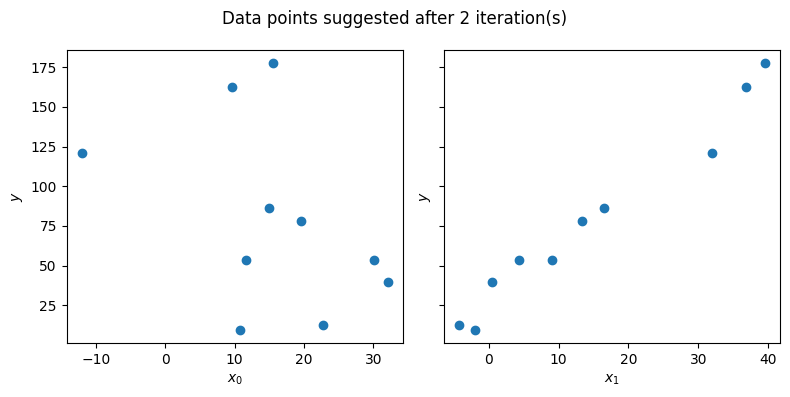

In [495]:
i = 1
d_example, y_example, (opt, _), __ = data_sets[i*50]
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4))
reg = linear_model.LinearRegression()
reg.fit(d_example, y_example)
print(reg.predict([d_example[0]]))
print(y_example[0])
#axes[0].scatter(di[:, 0],  diy, c='blue')
axes[0].scatter(d_example[:, 0], y_example)
xs = np.linspace(np.min(d_example), np.max(d_example), 100)
#axes[0].plot(xs, mean[0] * xs + mean[2], label="$theta_1 x + theta_3$")
#axes[0].plot(xs, mean_prior[0] * xs + mean_prior[2], label="$prior_1 x + prior_3$")
#axes[0].plot(xs, opt[0] * xs + opt[1] * xs + opt[2], label="Analytical Posterior Mean")
#axes[0].plot(xs, analytical[0] * xs + analytical[1] * xs + analytical[2], label="Analytical")
#axes[0].plot(xs, reg.coef_[0] * xs + reg.coef_[1] * xs + reg.intercept_, label="Minimum Least Squares")

axes[0].set_xlabel("$x_%s$" % (0))
axes[0].set_ylabel("$y$")
#axes[0].legend()

axes[1].scatter(d_example[:, 1], y_example)
xs = np.linspace(np.min(d_example), np.max(d_example), 100)
#axes[0].plot(xs, mean[0] * xs + mean[2], label="$theta_1 x + theta_3$")
#axes[0].plot(xs, mean_prior[0] * xs + mean_prior[2], label="$prior_1 x + prior_3$")
#axes[1].plot(xs,opt[0] * xs + opt[1] * xs + opt[2], label="Analytical Posterior Mean")
#axes[1].plot(xs, analytical[0] * xs + analytical[1] * xs + analytical[2], label="Analytical")
#axes[1].plot(xs, reg.coef_[0] * xs + reg.coef_[1] * xs + reg.intercept_, label="Minimum Least Squares")
axes[1].set_xlabel("$x_%s$" % (1))
axes[1].set_ylabel("$y$")
#axes[1].legend()
plt.suptitle("Data points suggested after %s iteration(s)" % (i + 1))
plt.tight_layout()
plt.show()

Text(0, 0.5, 'MI')

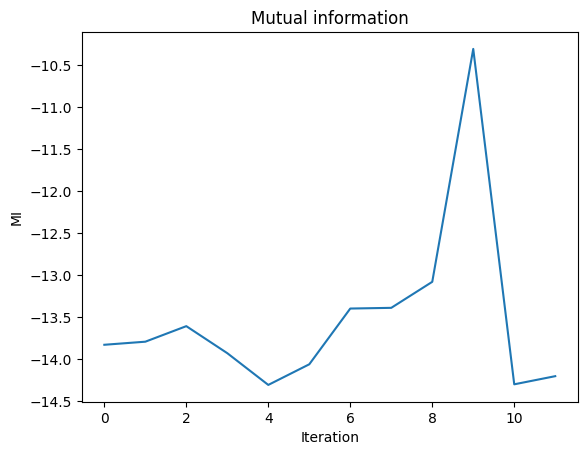

In [403]:
def mut_2(d, covariance_prior, dim=2):
    var_y = noise * np.eye(d.shape[0])
    cov_posterior = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    val = 0.5 * np.log(np.linalg.det(2*np.pi*np.e*cov_posterior)) - 0.5 * np.log(np.linalg.det(2*np.pi*np.e*covariance_prior))
    return val
plt.plot(np.arange(0, len(dis)), np.array([mut_2(np.array([d[:, 0], d[:, 1], np.ones(len(d))]).T, A_prior @ A_prior.T, dim=3) for d in dis]))
plt.title("Mutual information")
plt.xlabel("Iteration")
plt.ylabel("MI")

Text(0.5, 1.0, '$d$ at iteration 11')

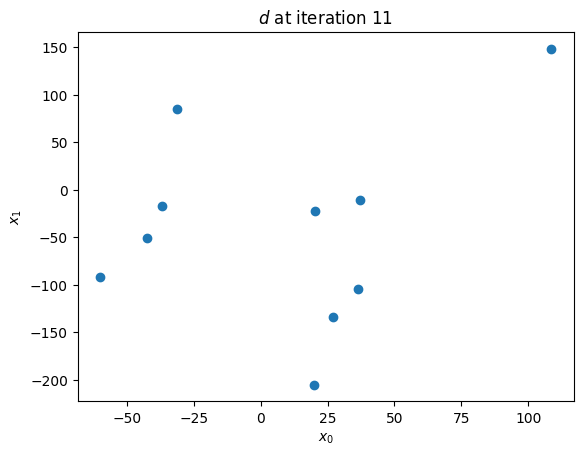

In [413]:
i = 10
di, q_params = list(zip(dis, optimal_params))[i]
mean = np.mean([mean for mean, A in q_params], axis=0)
diy = mean @ np.array([di[:, 0], di[:, 1], np.ones(len(di))])

# Contour
x1 = np.linspace(np.min(dis) - 10, np.max(dis) + 10, 500)
x2 = np.linspace(np.min(dis) - 10, np.max(dis) + 10, 500)
X1, X2 = np.meshgrid(x1, x2)

Z1 = mean_prior[0] * X1 + mean_prior[1] * X2 + mean_prior[2] * np.ones(500)

Z2 = mean[0] * X1 + mean[1] * X2 + mean[2] * np.ones(500)
#plt.contourf(X1, X2, Z2)

plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.scatter(di[:, 0], di[:, 1])
plt.title("$d$ at iteration %d" % (i + 1))

Text(0.5, 1.0, 'Norm of A at each iteration of MI algorithm')

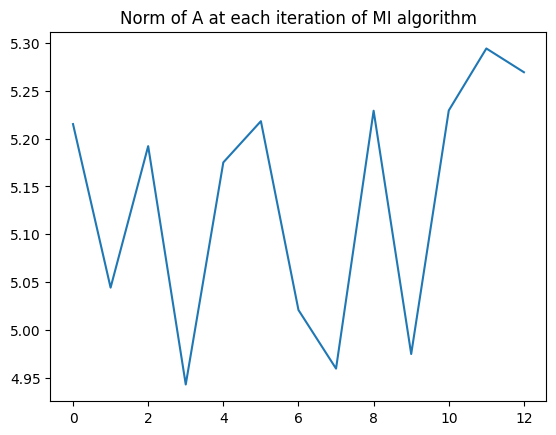

In [674]:
plt.plot(list(range(len(optimal_params))), [np.linalg.norm(np.mean([q_param[1] for q_param in q_params], axis=1)) for q_params in optimal_params])
plt.title("Norm of A at each iteration of MI algorithm")

Text(0.5, 1.0, 'Norm of mean at each iteration of MI algorithm')

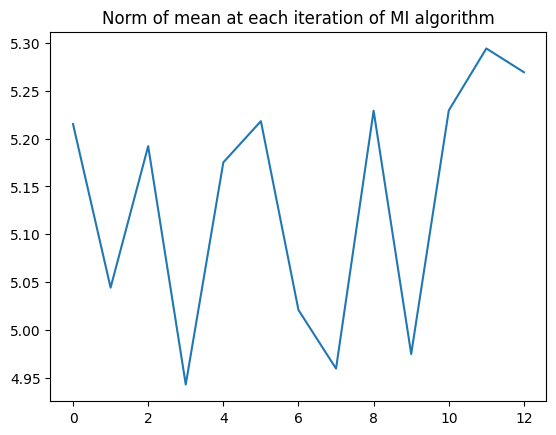

In [675]:
plt.plot(list(range(len(optimal_params))), [np.linalg.norm(np.mean([q_param[1] for q_param in q_params], axis=1)) for q_params in optimal_params])
plt.title("Norm of mean at each iteration of MI algorithm")

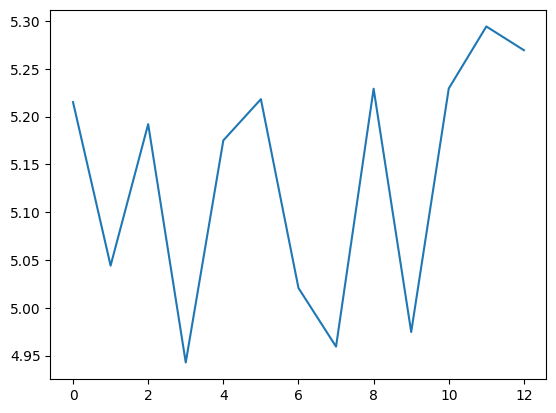

In [676]:
plt.plot(list(range(len(optimal_params))), [np.linalg.norm(np.mean([q_param[1] for q_param in q_params], axis=1)) for q_params in optimal_params])

In [ ]:
cache_1 = (dis, optimal_params)

# Tests

In [419]:
xs = np.array([[2.3, 2.6], [2.8, 2.9], [1, 2]])
mus = np.array([[2.5, 2.9], [1.7, 2.2], [1, 2]])
covs = np.array([A_prior[0:2, 0:2] @ A_prior[0:2, 0:2].T * 4, A_prior[0:2, 0:2] @ A_prior[0:2, 0:2].T, A_prior[0:2, 0:2] @ A_prior[0:2, 0:2].T])
print(timer(lambda: stable_multivariate_gaussian_logpdf(xs, mus, covs), label="Stable"))
print(timer(lambda: [stats.multivariate_normal.logpdf(x, mu, cov) for x, mu, cov in zip(xs, mus, covs)], label="Scipy"))

[-7.38373444 -6.02905019 -5.99676015]
[-7.383734442529533, -6.029050188831516, -5.996760149769017]


In [313]:
print(KLD(mean_prior, A_prior, mean_prior*2, A_prior*2))
print(KLD_opt(mean_prior, A_prior, mean_prior*2, A_prior*2))

-0.05533172695763178
0.2628154536023137


In [399]:
xs_ = np.random.rand(10, 2)
xs = np.hstack((xs_, np.ones((10, 1))))
zs = np.random.multivariate_normal(np.zeros(10), 3 * np.eye(10))
ys = np.dot(mean_prior, xs.T) + zs

xs_ = data_sets[50][0]
xs = np.hstack((xs_, np.ones((10, 1))))
zs = np.random.multivariate_normal(np.zeros(10), 3 * np.eye(10))
ys = data_sets[50][1]

In [235]:
print(log_likelihood(ys, np.array([mean_prior]).T, xs_))
print(log_likelihood_opt(ys, np.array([mean_prior]).T, xs_)) # MISMATCH: Fix this!

[-53.78214979145803]
[-53.78214979]


In [236]:
# 

Optimizing for q:   0%|          | 0/50 [00:00<?, ?it/s]

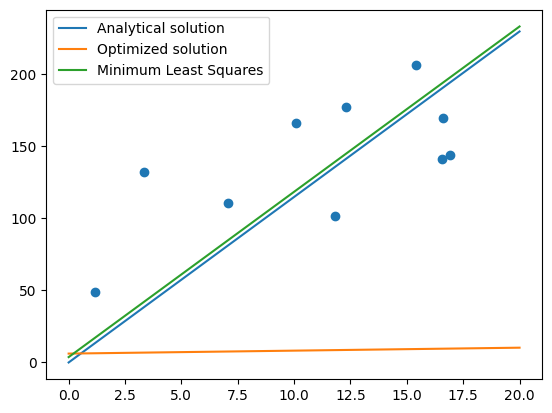

In [237]:
mu, A = analytical_optimal_q(xs[:, 0:2], ys)
(mu_o, A_o), thetas = optimal_q(xs[:, 0:2], ys, rate=30, decay=0.9, iters=50)
reg = linear_model.LinearRegression()
reg.fit(np.concatenate((xs.T, [np.ones(len(xs))]), axis=0).T, ys)
plt.scatter(xs[:, 0], ys)
plt.plot(np.linspace(0, 20, 100), mu[0] * np.linspace(0, 20, 100) + mu[1]* np.linspace(0, 20, 100) + mu[2] * np.ones(100), label="Analytical solution")
plt.plot(np.linspace(0, 20, 100), mu_o[0] * np.linspace(0, 20, 100) + mu_o[1]* np.linspace(0, 20, 100) + mu_o[2] * np.ones(100), label="Optimized solution")
plt.plot(np.linspace(0, 20, 100), reg.coef_[0] * np.linspace(0, 20, 100) + reg.coef_[1] * np.linspace(0, 20, 100) + reg.intercept_ * np.ones(100), label="Minimum Least Squares")
plt.legend()

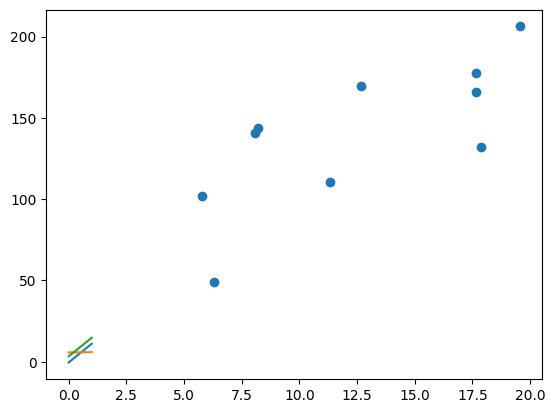

In [238]:
plt.scatter(xs[:, 1], ys)
plt.plot(np.linspace(0, 1, 100), mu[0] * np.linspace(0, 1, 100) + mu[1]* np.linspace(0, 1, 100) + mu[2] * np.ones(100), label="Analytical solution")
plt.plot(np.linspace(0, 1, 100), mu_o[0] * np.linspace(0, 1, 100) + mu_o[1]* np.linspace(0, 1, 100) + mu_o[2] * np.ones(100), label="Optimized solution")
plt.plot(np.linspace(0, 1, 100), reg.coef_[0] * np.linspace(0, 1, 100) + reg.coef_[1] * np.linspace(0, 1, 100) + reg.intercept_ * np.ones(100), label="Minimum Least Squares")

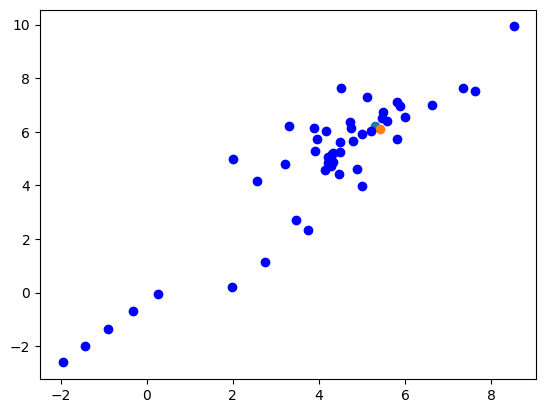

In [239]:
plt.scatter(reg.coef_[0], reg.coef_[1])
plt.scatter(mu[0], mu[1])
for i, mu_o in enumerate(thetas):
    plt.scatter(mu_o[0], mu_o[1], color="blue")

In [240]:
# Finite differences of ELBO
xs = np.array([[2.3, 2.6], [2.8, 2.9], [1, 2]])
mus = np.array([[2.5, 2.9], [1.7, 2.2], [1, 2]])
covs = np.array([A_prior[0:2, 0:2] @ A_prior[0:2, 0:2].T * 4, A_prior[0:2, 0:2] @ A_prior[0:2, 0:2].T, A_prior[0:2, 0:2] @ A_prior[0:2, 0:2].T])
elbo(, d, y_i, shape=3)

SyntaxError: invalid syntax (1397455608.py, line 5)

ValueError: x and y must have same first dimension, but have shapes (999,) and (49,)

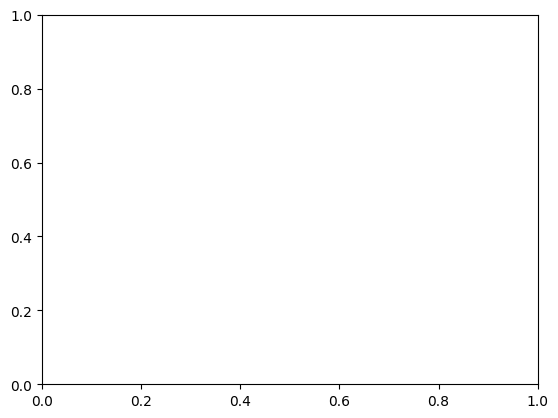

In [241]:
plt.plot(np.arange(0, 999), g_norms[1:1000])
plt.title("Gradient norm")

Text(0.5, 1.0, 'Step size')

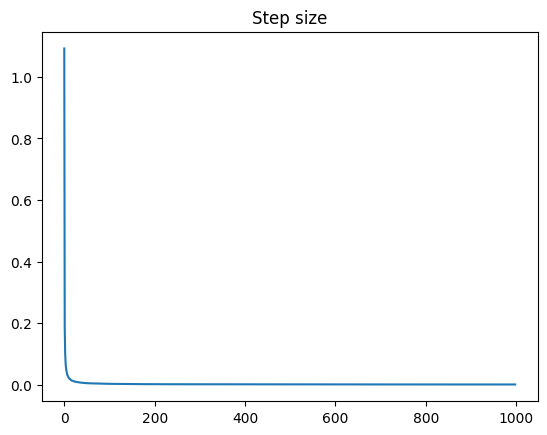

In [563]:
rate = 10
decay = 50
plt.plot(np.arange(0, 999), np.array([rate * 1/(10+i*decay) for i in np.arange(0, 999)]) * g_norms[1:1000])
plt.title("Step size")

ValueError: x and y must have same first dimension, but have shapes (999,) and (49,)

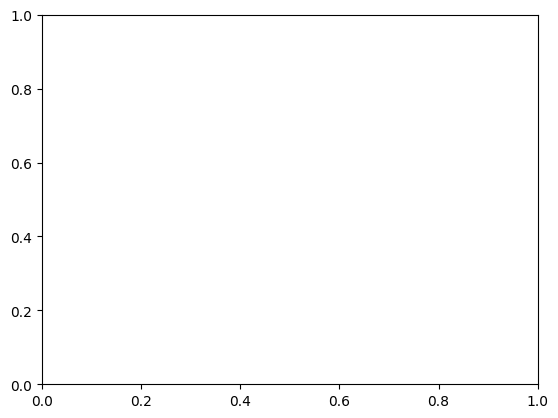

In [242]:
plt.plot(np.arange(0, 999), elbos[1:1000])
plt.title("ELBO")

In [244]:

print("Grad", log_posterior_grad(analytical_optimal_q(xs_, ys)[0], ys, xs_, analytical_optimal_q(xs_, ys)))
bef = log_posterior(analytical_optimal_q(xs_, ys)[0], analytical_optimal_q(xs_, ys))
aft = np.array([log_posterior(analytical_optimal_q(xs_, ys)[0], analytical_optimal_q(decode_d(encode_d(xs_) + np.eye(20)[dim] * 1e-5), ys)) for dim in range(20)])
#print("Finite difference", aft - bef)
print("Autograd", grad(lambda xs_: log_posterior(analytical_optimal_q(decode_d(xs_), ys)[0], analytical_optimal_q(decode_d(xs_), ys)))(encode_d(xs_)))

Grad [-0.03089705  0.12717746  0.06866883  0.09154727 -0.05757365 -0.04106498
  0.0780173  -0.09246831  0.00270578 -0.1850967   0.05314013  0.11923961
  0.01656128 -0.1260762   0.01825034  0.02360156  0.0571347  -0.05050574
  0.10562596  0.14744325]
Autograd [-0.02123385  0.02629851 -0.00315044  0.00830937 -0.00734354  0.00839519
  0.02167367 -0.01279574  0.02214265 -0.01308189 -0.00693277  0.01517666
  0.01554911 -0.00953746  0.00100643  0.01025268  0.01447962 -0.00440493
 -0.00238136  0.0116722 ]


In [15]:

optimizer(encode_d(d0), 
          grad(
              lambda xs_: log_posterior(
                  analytical_optimal_q(decode_d(xs_), ys)[0], 
                  analytical_optimal_q(decode_d(xs_), ys)
              )
          )
         )

  0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'ys' is not defined

In [349]:
A_prior @ A_prior.T

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])